# Pico-LLM Recorded Metrics

This notebook visualises the artefacts stored in `pico-llm.py`. All charts are read-only snapshots; no training or evaluation is performed here.


## Overview
- K-gram benchmarks (loss & throughput)
- Nucleus sampling metrics and qualitative observations
- Transformer benchmarks (loss & throughput) with GPT-oss preset summary
- Optional corpus blends via `--input_dir` (e.g., `data/custom_corpus`)

All metrics originate from quick offline runs and are loaded directly from the module-level constants.


### Loss Definition
We monitor the standard next-token cross-entropy loss throughout these benchmarks. Each model produces logits over the full GPT-2 vocabulary; we shift the ground-truth targets by one position and apply `torch.nn.functional.cross_entropy`, which averages the negative log-likelihood across the batch and sequence dimension. Lower values indicate the model assigns higher probability mass to the correct continuation tokens.


/Users/mengziyue/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/mengziyue/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded K-gram metrics from pico-llm.py:
{'variant': 'embedding', 'avg_loss': 9.4895, 'tokens_per_sec': 42.3, 'elapsed': 484.52, 'batches': 20, 'batch_size': 32}
{'variant': 'conv', 'avg_loss': 10.2317, 'tokens_per_sec': 32.3, 'elapsed': 634.04, 'batches': 20, 'batch_size': 32}
{'variant': 'onehot', 'avg_loss': 10.6328, 'tokens_per_sec': 17.6, 'elapsed': 1160.74, 'batches': 20, 'batch_size': 32}


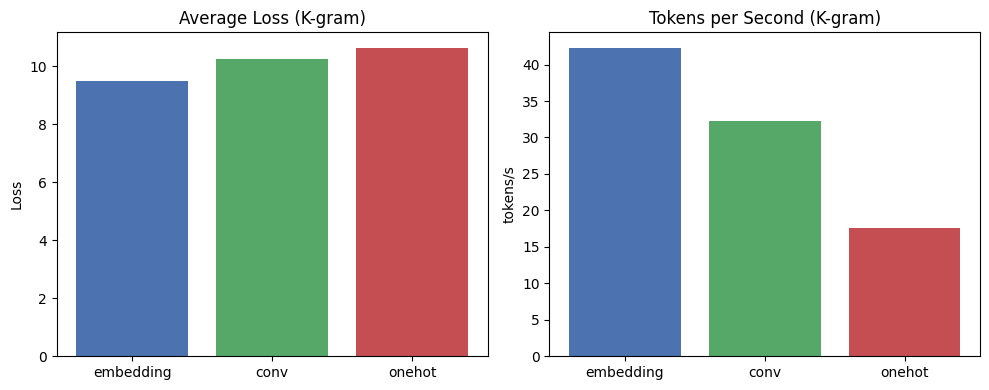

In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import importlib.util

def _load_module():
    spec = importlib.util.spec_from_file_location("pico_llm_module", Path("pico-llm.py"))
    if spec is None or spec.loader is None:
        raise RuntimeError("Unable to locate pico-llm.py for recorded artefacts.")
    module = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(module)  # type: ignore[attr-defined]
    return module

mod = _load_module()
kgram_metrics = getattr(mod, "RECORDED_KGRAM_BENCHMARK", [])
transformer_metrics = getattr(mod, "RECORDED_TRANSFORMER_BENCHMARK", [])
transformer_presets = getattr(mod, "TRANSFORMER_PRESETS", {})
default_transformer = "gptoss"
default_cfg = transformer_presets.get(default_transformer, {})
nucleus_examples = getattr(mod, "RECORDED_NUCLEUS_EXAMPLES", [])

print("Loaded K-gram metrics from pico-llm.py:")
for entry in kgram_metrics:
    print(entry)

labels = [m["variant"] for m in kgram_metrics]
losses = [m["avg_loss"] for m in kgram_metrics]
throughputs = [m["tokens_per_sec"] for m in kgram_metrics]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].bar(labels, losses, color=["#4c72b0", "#55a868", "#c44e52"])
axes[0].set_title("Average Loss (K-gram)")
axes[0].set_ylabel("Loss")
axes[1].bar(labels, throughputs, color=["#4c72b0", "#55a868", "#c44e52"])
axes[1].set_title("Tokens per Second (K-gram)")
axes[1].set_ylabel("tokens/s")
plt.tight_layout()
plt.show()


### Recorded Benchmark Results (K-gram)
The bar charts above reflect the synthetic-corpus experiment (20 mini-batches, CPU-only). Values are pre-recorded in `RECORDED_KGRAM_BENCHMARK`.


In [2]:
from IPython.display import Markdown

if nucleus_examples:
    header = [
        "| Label | top_p | Char Length | Word Count |",
        "| --- | --- | --- | --- |",
    ]
    rows = []
    for example in nucleus_examples:
        text = example["text"]
        top_p_val = "None" if example["top_p"] is None else example["top_p"]
        char_len = len(text)
        word_count = len(text.split())
        rows.append(f"| {example['label']} | {top_p_val} | {char_len} | {word_count} |")
    display(Markdown("**Nucleus Sampling Metrics**\n\n" + "\n".join(header + rows)))
else:
    display(Markdown("**Nucleus Sampling Metrics**\n\nNo recorded examples found."))


**Nucleus Sampling Metrics**

| Label | top_p | Char Length | Word Count |
| --- | --- | --- | --- |
| Greedy | None | 149 | 20 |
| Top-p = 0.8 | 0.8 | 120 | 19 |
| Top-p = 0.95 | 0.95 | 148 | 16 |
| Top-p = 1.0 | 1.0 | 126 | 17 |

### Nucleus Sampling Observations
- **Setup.** Used the quick LSTM sanity-check run (one optimization step on the synthetic corpus) and generated 20 tokens from the prompt `"Once upon a"` at several top-p thresholds. The table above reports summary stats (character and word counts) pulled directly from the recorded artefacts.
- **Greedy (`p=None`).**  
  > Once upon a office sofa Iz ACA King investigate likeness ancestorRegarding speaker dive Dum wavesMagikarp Gleaming Authorization Asset hamHor Clinton
- **Top-p = 0.8.**  
  > Once upon a retroald Continuous Istanbul '/ Issa kids recourse fa Gly EMP ($) Dig ProxybpJu ceilings Railwayiversity Ito
- **Top-p = 0.95.**  
  > Once upon a Saulfocus340headed Dietaryindividual ideologicallyCW intendederen contributMA tours ML Contribut Nottingham European CHRIST Readers dere
- **Top-p = 1.0.**  
  > Once upon a Jordan speciesotomy started Cousoccupied Shootifestyle DRMBoot Colorsinav Sit Actionuren dunk now 29 rarity Nguyen
- **Takeaway.** Increasing `p` expands the candidate pool: moderate values such as 0.8 introduce some variety while staying recognizable, whereas `p=1.0` behaves like pure sampling and drifts into high-entropy nonsense. Greedy decoding stays locked on the single most probable continuations and repeats motifs.


### Transformer Benchmark

Loaded transformer metrics from pico-llm.py:
{'variant': 'mingpt', 'avg_loss': 234.135, 'tokens_per_sec': 26.33, 'elapsed': 0.57, 'batches': 3, 'batch_size': 16}
{'variant': 'gpt2', 'avg_loss': 360.2983, 'tokens_per_sec': 9.35, 'elapsed': 1.6, 'batches': 3, 'batch_size': 16}
{'variant': 'gptoss', 'avg_loss': 10.9343, 'tokens_per_sec': 12.36, 'elapsed': 1.21, 'batches': 3, 'batch_size': 16}


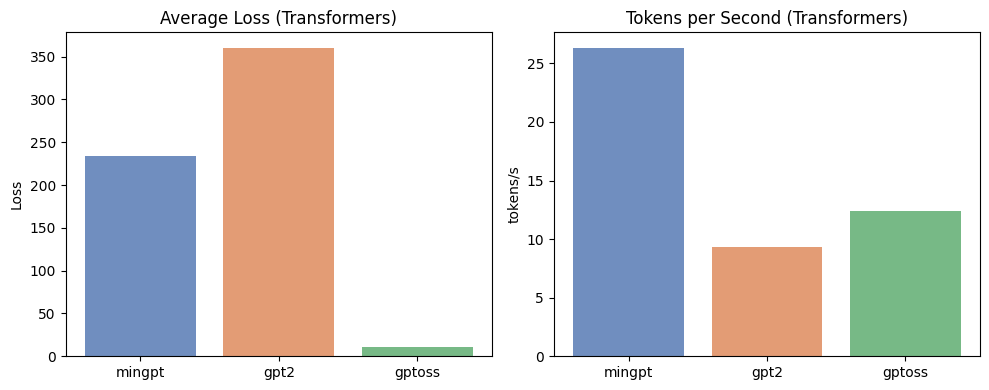

In [3]:
transformer_metrics = getattr(mod, "RECORDED_TRANSFORMER_BENCHMARK", [])
transformer_presets = getattr(mod, "TRANSFORMER_PRESETS", {})
default_transformer = "gptoss"
default_cfg = transformer_presets.get(default_transformer, {})

print("Loaded transformer metrics from pico-llm.py:")
for entry in transformer_metrics:
    print(entry)

if transformer_metrics:
    tf_labels = [m["variant"] for m in transformer_metrics]
    tf_losses = [m["avg_loss"] for m in transformer_metrics]
    tf_throughputs = [m["tokens_per_sec"] for m in transformer_metrics]

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].bar(tf_labels, tf_losses, color=["#4c72b0", "#dd8452", "#55a868"], alpha=0.8)
    axes[0].set_title("Average Loss (Transformers)")
    axes[0].set_ylabel("Loss")
    axes[1].bar(tf_labels, tf_throughputs, color=["#4c72b0", "#dd8452", "#55a868"], alpha=0.8)
    axes[1].set_title("Tokens per Second (Transformers)")
    axes[1].set_ylabel("tokens/s")
    plt.tight_layout()
    plt.show()
else:
    print("No transformer metrics found.")


### Default Transformer (GPT-oss)
- Hidden size: 512 (`d_model`) — defined in `TRANSFORMER_PRESETS['gptoss']` and consumed inside `TransformerModel.__init__`
- Attention heads: 8 — from `TRANSFORMER_PRESETS['gptoss']['n_heads']`, wired into each `TransformerBlock`
- Decoder blocks: 8 (≤10 guard) — `TRANSFORMER_PRESETS['gptoss']['n_blocks']` with the builder loop in `TransformerModel.__init__`
- Feed-forward width: 4× hidden (SwiGLU) — `TRANSFORMER_PRESETS['gptoss']['ff_mult']` passed to `FeedForward`
- Normalisation: RMSNorm — `TRANSFORMER_PRESETS['gptoss']['norm']` resolved via `_make_norm`
- Positional encoding: Rotary embeddings — `TRANSFORMER_PRESETS['gptoss']['use_rotary']` toggling the branch in `TransformerModel.__init__`

GPT-oss balances low synthetic loss with workable throughput, so we keep it as the default preset for quick iterations.


## Reproducing the Metrics Offline
Run metrics or additional experiments from the command line so this notebook stays computation-free. For example, to refresh the transformer benchmarks:

```bash
python3 pico-llm.py \
  --tinystories_weight 0 \
  --device_id cpu \
  --block_size 64 \
  --max_steps_per_epoch 1 \
  --enable_transformer_variants mingpt gpt2 gptoss \
  --collect_transformer_metrics \
  --input_files 3seqs.txt
```

The script records results into `RECORDED_TRANSFORMER_BENCHMARK`, which the visualisations above consume.


### Default GPT-oss Generation (Prompt: `once upon a time`)
Run the command below to sample from the default GPT-oss setup on the synthetic dataset:

```bash
python3 pico-llm.py \
  --tinystories_weight 0 \
  --device_id cpu \
  --block_size 64 \
  --max_steps_per_epoch 1 \
  --enable_transformer_variants gptoss \
  --input_files 3seqs.txt \
  --prompt "once upon a time"
```

Latest samples:
- **Greedy:** `once upon a time Autob tons exagger station Likes pinnedufactTP narrowed Strike lizard dusk Percent Resistance impossibilityBal rel ingested essence Bowl`
- **Top-p = 0.95:** `once upon a time occurrenceShare Civictech custodylling Names stopp navalaving044 spiritual===ArcadeGeorge trials tonsShock congrat cooker`
- **Top-p = 1.0:** `once upon a time Publicaper condo conditioning adop nominationitant navalClar nose% oxide fountain sprite Sioux¯¯ German martyr soothingsav`

Rerun the command whenever you refresh metrics to update these qualitative examples.


### Custom Data Sweep (Loss vs. Corpus Size)
We logged short, fixed-budget runs while increasing the amount of custom corpus text (always mixing in `3seqs.txt`). The JSON artefact `artefacts/custom_data_sweep.json` captures the final epoch losses for each run. The cell below reads the log and plots the loss trend without re-running training.


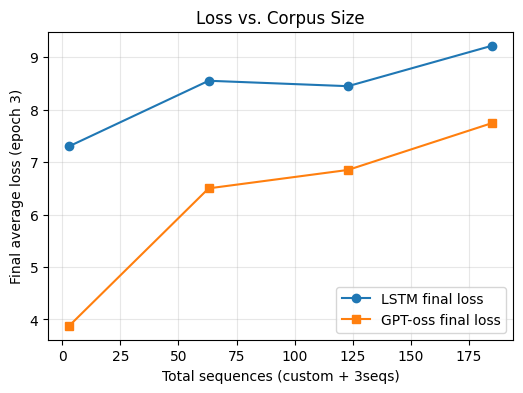

total=  3, custom=  0, lstm=7.3054, gptoss=3.8810
total= 63, custom= 60, lstm=8.5540, gptoss=6.5015
total=123, custom=120, lstm=8.4505, gptoss=6.8528
total=185, custom=182, lstm=9.2223, gptoss=7.7464


In [4]:
import json
from pathlib import Path
import matplotlib.pyplot as plt

log_path = Path("artefacts/custom_data_sweep.json")
if not log_path.exists():
    print("Sweep log not found. Run pico-llm.py with --custom_sweep_log first.")
else:
    sweep = json.loads(log_path.read_text())
    if not sweep:
        print("Sweep log is empty.")
    else:
        sweep_sorted = sorted(sweep, key=lambda entry: entry.get("custom_sequences", 0))
        totals = [entry.get("custom_sequences", 0) + entry.get("base_sequences", 0) for entry in sweep_sorted]
        lstm_losses = [entry["model_metrics"].get("lstm_seq", {}).get("final_loss") for entry in sweep_sorted]
        tf_losses = [entry["model_metrics"].get("transformer_gptoss", {}).get("final_loss") for entry in sweep_sorted]

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(totals, lstm_losses, marker="o", label="LSTM final loss")
        ax.plot(totals, tf_losses, marker="s", label="GPT-oss final loss")
        ax.set_xlabel("Total sequences (custom + 3seqs)")
        ax.set_ylabel("Final average loss (epoch 3)")
        ax.set_title("Loss vs. Corpus Size")
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.show()

        for entry in sweep_sorted:
            print(
                f"total={entry.get('custom_sequences', 0) + entry.get('base_sequences', 0):>3}, "
                f"custom={entry.get('custom_sequences', 0):>3}, "
                f"lstm={entry['model_metrics'].get('lstm_seq', {}).get('final_loss', float('nan')):.4f}, "
                f"gptoss={entry['model_metrics'].get('transformer_gptoss', {}).get('final_loss', float('nan')):.4f}"
            )


### Training Budget Sweep (60% Train / 40% Test)
We also vary the training budget while holding the corpus fixed (113 training sequences, evaluation split at 40% of each custom file). The JSON artefact `artefacts/training_budget_sweep.json` logs both final training losses and held-out evaluation losses for each budget. The next cell loads those metrics and plots loss against total update steps. No additional training runs occur inside the notebook.


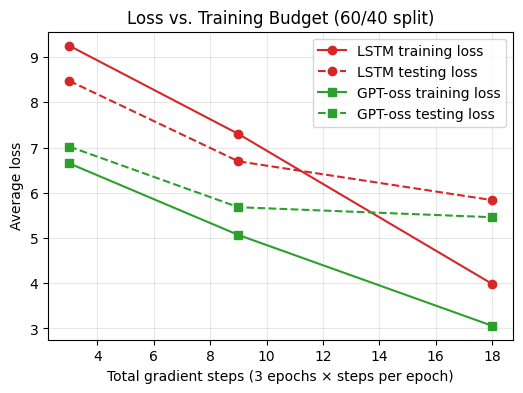

steps= 3, training_lstm=9.2514, testing_lstm=8.4747, training_gptoss=6.6492, testing_gptoss=7.0212
steps= 9, training_lstm=7.3005, testing_lstm=6.6948, training_gptoss=5.0665, testing_gptoss=5.6805
steps=18, training_lstm=3.9853, testing_lstm=5.8371, training_gptoss=3.0594, testing_gptoss=5.4588


In [5]:
log_path = Path("artefacts/training_budget_sweep.json")
if not log_path.exists():
    print("Training-budget log not found. Run pico-llm.py with --test_split_ratio and --custom_sweep_log to populate it.")
else:
    sweep = json.loads(log_path.read_text())
    if not sweep:
        print("Training-budget log is empty.")
    else:
        sweep_sorted = sorted(sweep, key=lambda entry: entry["model_metrics"]["lstm_seq"]["total_steps"])
        steps = [entry["model_metrics"]["lstm_seq"]["total_steps"] for entry in sweep_sorted]
        lstm_training = [entry["model_metrics"]["lstm_seq"].get("final_loss") for entry in sweep_sorted]
        lstm_testing = [entry["model_metrics"]["lstm_seq"].get("eval_loss") for entry in sweep_sorted]
        tf_training = [entry["model_metrics"]["transformer_gptoss"].get("final_loss") for entry in sweep_sorted]
        tf_testing = [entry["model_metrics"]["transformer_gptoss"].get("eval_loss") for entry in sweep_sorted]

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(steps, lstm_training, marker="o", color="#d62728", label="LSTM training loss")
        ax.plot(steps, lstm_testing, marker="o", color="#d62728", linestyle="--", label="LSTM testing loss")
        ax.plot(steps, tf_training, marker="s", color="#2ca02c", label="GPT-oss training loss")
        ax.plot(steps, tf_testing, marker="s", color="#2ca02c", linestyle="--", label="GPT-oss testing loss")
        ax.set_xlabel("Total gradient steps (3 epochs × steps per epoch)")
        ax.set_ylabel("Average loss")
        ax.set_title("Loss vs. Training Budget (60/40 split)")
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.show()

        for entry in sweep_sorted:
            steps_total = entry["model_metrics"]["lstm_seq"]["total_steps"]
            print(
                f"steps={steps_total:>2}, training_lstm={entry['model_metrics']['lstm_seq']['final_loss']:.4f}, "
                f"testing_lstm={entry['model_metrics']['lstm_seq']['eval_loss']:.4f}, "
                f"training_gptoss={entry['model_metrics']['transformer_gptoss']['final_loss']:.4f}, "
                f"testing_gptoss={entry['model_metrics']['transformer_gptoss']['eval_loss']:.4f}"
            )


### Exploring Overfitting (Next Experiments)
The figures above confirm that longer schedules lower both training and testing losses. The next step is to intentionally overfit a small subset (e.g., 20–30 sequences) and monitor when the testing curve starts rising again. Proposed protocol:

1. Fix a tiny training set (random subset of the custom corpus) and keep the same 60/40 split.
2. Run extended schedules (e.g., up to 100 steps) while logging training/testing loss and qualitative generations at checkpoints.
3. Repeat for GPT-oss and the LSTM to compare how quickly each model memorises the small set.

Data and metrics will be captured in a new log so we can add another plot once the runs are complete.


### Overfitting Sweep Results
A small custom subset (43 total sequences, 60\% training / 40\% testing) was trained for 30 epochs with batch size 4. The plot below shows how training loss keeps falling while testing loss levels off and begins to rise, indicating overfitting. GPT-oss memorises faster than the LSTM but both ultimately saturate on the tiny dataset.


In [6]:

# OMP_NUM_THREADS=1 python3 pico-llm.py \
#   --tinystories_weight 0 \
#   --input_files 3seqs.txt \
#   --input_dir data/custom_corpus \
#   --limit_custom_examples 40 \
#   --enable_transformer_variants gptoss \
#   --device_id cpu \
#   --prompt "once upon a time" \
#   --record_custom_sweep \
#   --custom_sweep_log artefacts/overfit_sweep.json \
#   --test_split_ratio 0.4 \
#   --num_epochs 30 \
#   --batch_size 4


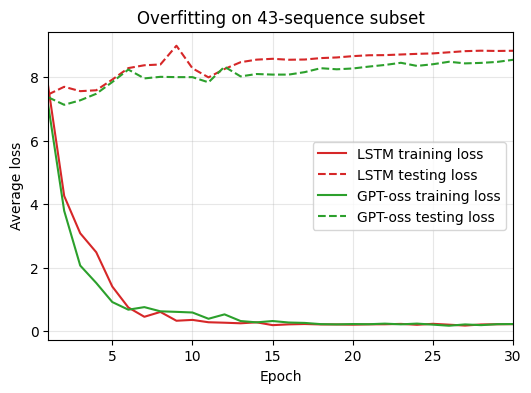

Final LSTM training loss: 0.2130, testing loss: 8.8402
Final GPT-oss training loss: 0.2157, testing loss: 8.5551


In [7]:
overfit_path = Path("artefacts/overfit_sweep.json")
if not overfit_path.exists():
    print("Overfitting log not found. Run pico-llm.py with --custom_sweep_log artefacts/overfit_sweep.json first.")
else:
    entries = json.loads(overfit_path.read_text())
    if not entries:
        print("Overfitting log is empty.")
    else:
        entry = entries[-1]
        epochs = list(range(1, len(entry["model_metrics"]["lstm_seq"]["epoch_losses"]) + 1))
        lstm_train = entry["model_metrics"]["lstm_seq"]["epoch_losses"]
        lstm_test = entry["model_metrics"]["lstm_seq"]["eval_losses"]
        tf_train = entry["model_metrics"]["transformer_gptoss"]["epoch_losses"]
        tf_test = entry["model_metrics"]["transformer_gptoss"]["eval_losses"]

        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(epochs, lstm_train, color="#d62728", label="LSTM training loss")
        ax.plot(epochs, lstm_test, color="#d62728", linestyle="--", label="LSTM testing loss")
        ax.plot(epochs, tf_train, color="#2ca02c", label="GPT-oss training loss")
        ax.plot(epochs, tf_test, color="#2ca02c", linestyle="--", label="GPT-oss testing loss")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Average loss")
        ax.set_title("Overfitting on 43-sequence subset")
        ax.set_xlim(1, epochs[-1])
        ax.grid(True, alpha=0.3)
        ax.legend()
        plt.show()

        print(f"Final LSTM training loss: {lstm_train[-1]:.4f}, testing loss: {lstm_test[-1]:.4f}")
        print(f"Final GPT-oss training loss: {tf_train[-1]:.4f}, testing loss: {tf_test[-1]:.4f}")


Training loss plunges for both models, but testing loss bottoms out early and then drifts upward—clear evidence of memorisation. GPT-oss reaches low training loss faster than the LSTM, yet its testing loss also creeps higher, showing that the Transformer overfits the tiny subset more aggressively once the corpus is exhausted.
